In [1]:
##CONEXIÓN CON EL BRAZALETE EMG
#Para comunicacion serial
import serial
import time
from myo import init, Hub, DeviceListener
#Para manejar el tiempo
from collections import deque
from IPython.display import display, clear_output 

#Para encontrar seriales disponibles
import serial.tools.list_ports as list_ports

# Para procesar y visualizar los datos
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks

# Para entrenar el modelo y medir su rendimiento
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# CONEXION CON LA PAGINA WEB
import requests as req

import os

ANALISIS DE LOS DATOS

In [2]:
#Detectando puntos seriales disponibles
encontrado = False
puertos = list_ports.comports()
for puerto in puertos:
    print(f"Puerto: {puerto.device} - descripcion: {puerto.description}")
    encontrado = True
if not encontrado:
    print("No se encontró ningún puerto serial.")

No se encontró ningún puerto serial.


In [3]:
#Se cambia por el puerto correcto y la velocidad (baudrate) segun el brazalete EMG
Puerto = "COM9"
bautrate = 115200

try:
    #Abre la conexión serial
    ser = serial.Serial(Puerto, bautrate, timeout=1)
    print(f"conectando al puerto {Puerto} a {bautrate} baudios")

    #Se lee los datos durante 5 segundos (por el momento)
    start_time = time.time()
    while time.time() - start_time < 10:
        if ser.in_waiting:
            linea = ser.readline().decode('utf-8', error='ignore').strip() 
            print(f"Datos recibidos: {linea}")
    ser.close()
except serial.SerialException as e:
    print(f"{Puerto}: {e}")

COM9: could not open port 'COM9': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)


ANALISIS DEL CSV

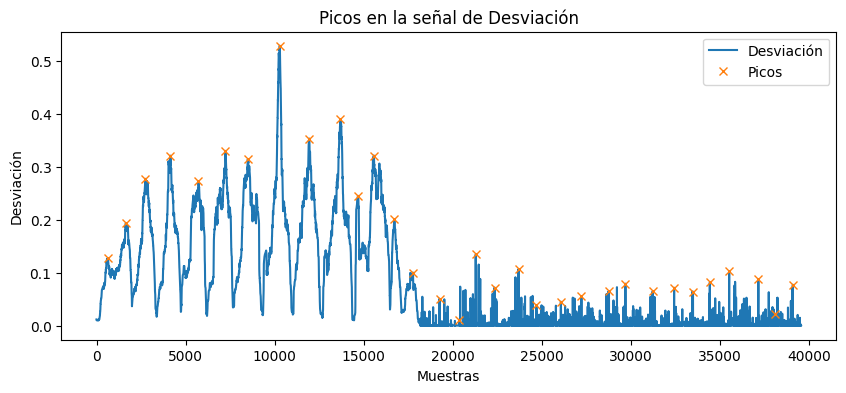

In [4]:
df = pd.read_csv("datasetV2.csv")

# Detecta picos en la desviación
peaks, _ = find_peaks(df['Desviacion'], height=None, distance=880)

plt.figure(figsize=(10,4))
plt.plot(df['Desviacion'], label='Desviación')
plt.plot(peaks, df['Desviacion'][peaks], "x", label='Picos')
plt.legend()
plt.title('Picos en la señal de Desviación')
plt.xlabel('Muestras')
plt.ylabel('Desviación')
plt.show()

Número de repeticiones (picos en el umbral): 1


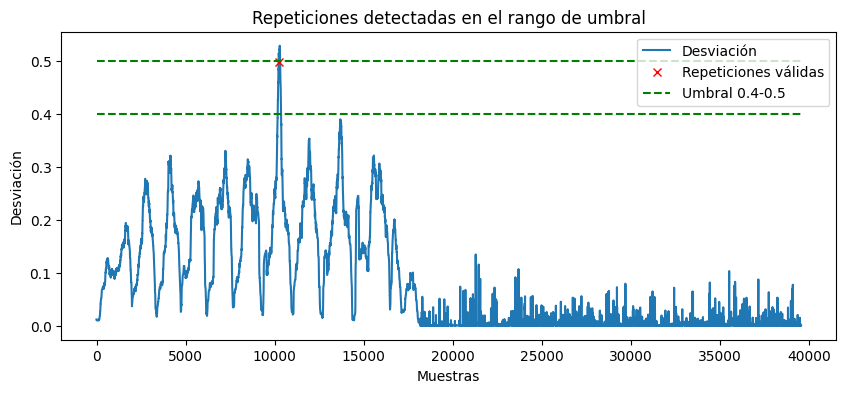

In [5]:
umbral_bajo = 0.4
umbral_alto = 0.5
peaks, properties = find_peaks(df['Desviacion'], height=umbral_bajo)

# Filtra solo los picos que están dentro del rango de umbral
picos_validos = [p for p in peaks if umbral_bajo <= df['Desviacion'][p] <= umbral_alto]

if picos_validos:
    pico_max = max(picos_validos, key=lambda p: df['Desviacion'][p])
    picos_validos = [pico_max]

print(f"Número de repeticiones (picos en el umbral): {len(picos_validos)}")

# Visualiza los picos válidos
plt.figure(figsize=(10,4))
plt.plot(df['Desviacion'], label='Desviación')
plt.plot(picos_validos, df['Desviacion'][picos_validos], "rx", label='Repeticiones válidas')
plt.hlines([umbral_bajo, umbral_alto], 0, len(df)-1, colors='green', linestyles='dashed', label='Umbral 0.4-0.5')
plt.legend()
plt.title('Repeticiones detectadas en el rango de umbral')
plt.xlabel('Muestras')
plt.ylabel('Desviación')
plt.show()

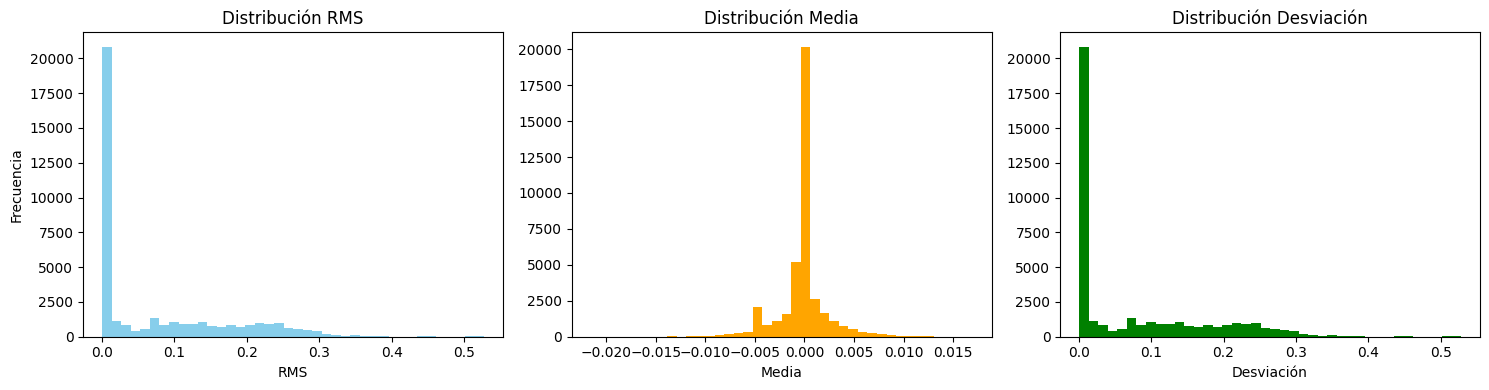

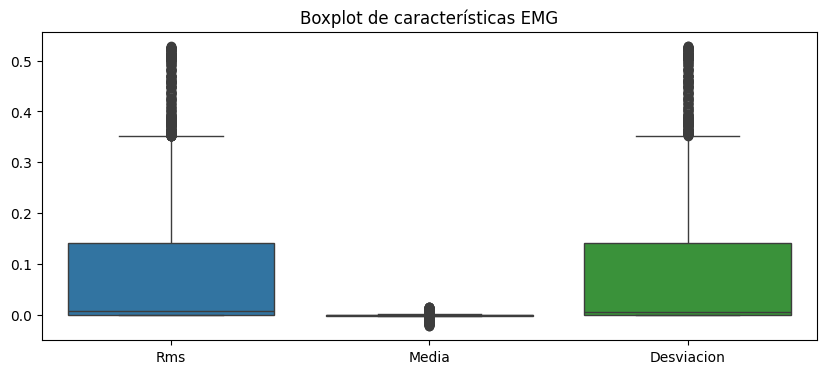

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("datasetV2.csv")

# Histograma de cada variable
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.hist(df['Rms'], bins=40, color='skyblue')
plt.title('Distribución RMS')
plt.xlabel('RMS')
plt.ylabel('Frecuencia')

plt.subplot(1,3,2)
plt.hist(df['Media'], bins=40, color='orange')
plt.title('Distribución Media')
plt.xlabel('Media')

plt.subplot(1,3,3)
plt.hist(df['Desviacion'], bins=40, color='green')
plt.title('Distribución Desviación')
plt.xlabel('Desviación')

plt.tight_layout()
plt.show()

# Boxplot para ver outliers y rango
plt.figure(figsize=(10,4))
sns.boxplot(data=df[['Rms', 'Media', 'Desviacion']])
plt.title('Boxplot de características EMG')
plt.show()

In [7]:
ventana = 100  # O el tamaño que corresponda a una repetición
segmentos = []

for i in range(0, len(df), ventana):
    segmento = df['Desviacion'].values[i:i+ventana]
    if len(segmento) == ventana:
        segmentos.append(segmento)

In [11]:
ventana = 100  # Ajusta según corresponda
segmentos = []
for i in range(0, len(df), ventana):
    segmento = df['Desviacion'].values[i:i+ventana]
    if len(segmento) == ventana:
        segmentos.append(segmento)

# Extrae características de cada segmento
X = [extraer_caracteristicas(seg) for seg in segmentos]

# Si no tienes etiquetas, puedes analizar X, hacer clustering, o guardar para etiquetar después
print(f"Segmentos procesados: {len(X)}")
print("Primeras características extraídas:", X[:3])

Segmentos procesados: 395
Primeras características extraídas: [[0.011218437258787144, 0.0006563369062139423, 0.0126040508855012, 0.010587946541154, 0.011237620418211414], [0.014339257931750447, 0.0037335988068832576, 0.0256083339731602, 0.0104610747752713, 0.01481735732457135], [0.047260005435303405, 0.01130044317432412, 0.0671468079320779, 0.0257665726408303, 0.04859226409297098]]


In [8]:
def extraer_caracteristicas(datos):
    #Extrae características de los datos EMG.
    return [
        np.mean(datos),
        np.std(datos),
        np.max(datos),
        np.min(datos),
        calcular_rms(datos)
    ]

In [10]:
def calcular_rms(datos):
    return np.sqrt(np.mean(np.square(datos)))

Segmentos procesados: 395
Primeras características extraídas: [[0.011218437258787144, 0.0006563369062139423, 0.0126040508855012, 0.010587946541154, 0.011237620418211414], [0.014339257931750447, 0.0037335988068832576, 0.0256083339731602, 0.0104610747752713, 0.01481735732457135], [0.047260005435303405, 0.01130044317432412, 0.0671468079320779, 0.0257665726408303, 0.04859226409297098]]


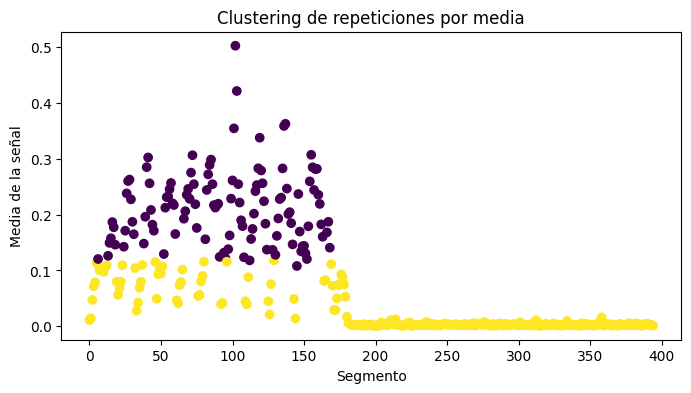

In [12]:
ventana = 100  # Ajusta según corresponda a la duración de una repetición
segmentos = []
for i in range(0, len(df), ventana):
    segmento = df['Desviacion'].values[i:i+ventana]
    if len(segmento) == ventana:
        segmentos.append(segmento)

# Extrae características de cada segmento
X = [extraer_caracteristicas(seg) for seg in segmentos]

print(f"Segmentos procesados: {len(X)}")
print("Primeras características extraídas:", X[:3])

# Ejemplo de análisis: clustering no supervisado (agrupamiento)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(8,4))
plt.scatter([i for i in range(len(X))], [x[0] for x in X], c=labels, cmap='viridis')
plt.xlabel("Segmento")
plt.ylabel("Media de la señal")
plt.title("Clustering de repeticiones por media")
plt.show()

DESARROLLO DE MODELOS Y CLASIFICACION 

In [13]:
umbral_bajo = 0.15  # Ajusta según la concentración de tu señal
peaks, _ = find_peaks(df['Desviacion'], height=umbral_bajo, distance=80)  # distance ~ duración mínima entre repeticiones

print(f"Picos detectados: {len(peaks)}")

# Segmenta 100 muestras alrededor de cada pico (50 antes y 50 después)
ventana = 100
segmentos = []
for p in peaks:
    inicio = max(p - ventana//2, 0)
    fin = min(p + ventana//2, len(df))
    segmento = df['Desviacion'].values[inicio:fin]
    if len(segmento) == ventana:
        segmentos.append(segmento)

print(f"Segmentos extraídos: {len(segmentos)}")

# Extrae características de cada segmento
X = [extraer_caracteristicas(seg) for seg in segmentos]

print("Primeras características extraídas:", X[:3])

Picos detectados: 95
Segmentos extraídos: 95
Primeras características extraídas: [[0.14599119642437444, 0.0053882604084711004, 0.153468817697355, 0.131733964805662, 0.1460905978619082], [0.16065206984117814, 0.007807728993182724, 0.180886504566078, 0.147774566101339, 0.16084168668689644], [0.18590915976867536, 0.00663768879361599, 0.194172469980101, 0.15765289147037, 0.18602761783782465]]


Entrenando modelo con clustering

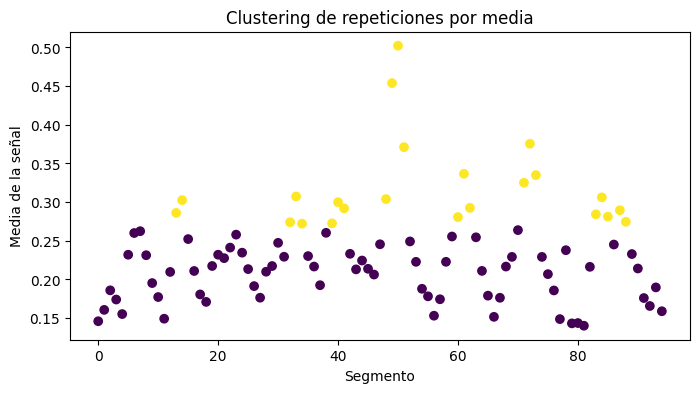

In [14]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(8,4))
plt.scatter([i for i in range(len(X))], [x[0] for x in X], c=labels, cmap='viridis')
plt.xlabel("Segmento")
plt.ylabel("Media de la señal")
plt.title("Clustering de repeticiones por media")
plt.show()

Lectura, enviar resultados en tiempo real a la web y clasificacion, en tiempo real

In [15]:
resultados = pd.DataFrame(X, columns=['media', 'std', 'max', 'min', 'rms'])
resultados['grupo'] = labels
resultados.to_csv("resultados_clustering.csv", index=False)

In [16]:
# 1. Determina qué grupo es mayor activación
grupo_0_media = resultados[resultados['grupo'] == 0]['media'].mean()
grupo_1_media = resultados[resultados['grupo'] == 1]['media'].mean()

if grupo_0_media > grupo_1_media:
    grupo_alta = 0
else:
    grupo_alta = 1

In [17]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.5515800662850072


In [ ]:
ser = serial.Serial(Puerto, bautrate, timeout=1)
datos_repetidos = []
try:
    print("leyendo datos en tiempo real...")
    while True:
        if ser.in_waiting:
            linea = ser.readline().decode('utf-8', error='ignore').strip()
            try:
                valor = float(linea)
                datos_repetidos.append(valor)
                if len(datos_repetidos) == ventana:
                    carac = extraer_caracteristicas(np.array(datos_repetidos))
                    grupo_predicho = kmeans.predict([carac])[0]
                    if grupo_predicho == grupo_alta:
                        estado = "contracción"
                    else:
                        estado = "no contracción"
                    print(f"Clasificación en tiempo real: {estado}")
                    # Enviar el resultado a la web
                    print(f"Enviando estado: {estado}")
                    req.post("http://localhost:5000/estado", json={"estado": estado})
                    datos_repetidos.clear()
            except ValueError:
                pass
except KeyboardInterrupt:
    print("Lectura interrumpida por el usuario.")
finally:
    ser.close()
    print("Conexión cerrada.")


In [ ]:
ser = serial.Serial(Puerto, bautrate, timeout=1)
datos_repetidos = []
try:
    print("leyendo datos en tiempo real...")
    while True:
        if ser.in_waiting:
            linea = ser.readline().decode('utf-8', error='ignore').strip()
            try:
                valor = float(linea)
                datos_repetidos.append(valor)
                if len(datos_repetidos) == ventana:
                    estado = "contracción"  # <-- Cambia aquí
                    print(f"Enviando estado: {estado}")
                    req.post("http://localhost:5000/estado", json={"estado": estado})
                    datos_repetidos.clear()
            except ValueError:
                pass
except KeyboardInterrupt:
    print("Lectura interrumpida por el usuario.")
finally:
    ser.close()
    print("Conexión cerrada.")

In [ ]:


import time
import requests as req

while True:
    estado = "contracción"
    print(f"Enviando estado: {estado}")
    req.post("http://localhost:5000/estado", json={"estado": estado})
    time.sleep(2)  

In [ ]:
import pyomyo.src.pyomyo.pyomyo

m = Myo()
m.connect()

m.set_emg_mode(emg_mode.FILTERED)

emg_data = [0] * 8

estado_anterior = None

def on_emg(emg):
    global emg_data
    emg_data = emg

m.add_emg_handler(on_emg)

try:
    print("Monitorizando contracción muscular... Ctrl+C para salir.")
    while True:
        m.run(1)  

        actividad = sum(abs(val) for val in emg_data) / len(emg_data)

        umbral = 20

        if actividad > umbral:
            estado_actual = "contracción"
        else:
            estado_actual = "reposo"

        if estado_actual != estado_anterior:
            if estado_actual == "contracción":
                print("💪 Contracción muscular detectada")
            else:
                print("🧘 No hay contracción")
            estado_anterior = estado_actual

        # Pequeño retardo para evitar saturar la salida
        time.sleep(0.05)

except KeyboardInterrupt:
    print("Finalizado por el usuario")
finally:
    m.disconnect()


In [ ]:
import pygame
from pygame.locals import *
import multiprocessing
import time  

from pyomyo import Myo, emg_mode

q = multiprocessing.Queue()
m = Myo(mode=emg_mode.PREPROCESSED)  
m.connect()


emg_data = [0] * 8
estado_anterior = None

def on_emg(emg):
    global emg_data
    emg_data = emg

m.add_emg_handler(on_emg)

try:
    print("Monitorizando contracción muscular... Ctrl+C para salir.")
    while True:
        m.run()

        actividad = sum(abs(val) for val in emg_data) / len(emg_data)
        umbral = 20

        if actividad > umbral:
            estado_actual = "contracción"
        else:
            estado_actual = "reposo"

        if estado_actual != estado_anterior:
            if estado_actual == "contracción":
                print("💪 Contracción muscular detectada")
            else:
                print("🧘 No hay contracción")
            estado_anterior = estado_actual

        time.sleep(0.05)

except KeyboardInterrupt:
    print("Finalizado por el usuario")
finally:
    m.disconnect()
